In [1]:
## Load in result for Variance Figure

import torch
import numpy as np
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torchvision import datasets
import scipy.stats as stats 
import matplotlib.pyplot as plt
import utils.metrics as metrics

In [2]:
def array_to_numpy(x):
    if torch.is_tensor(x):
        return x.detach().cpu().numpy()
    elif isinstance(x, np.ndarray):
        return x
    else:
        return 'ERR'

def ax_violin(ax,var_dict,set_sigma=False, legend_true=False, fs = 12, title=None):
    ticks = list(var_dict.keys())
    
    id_correct_var_list = []
    id_incorrect_var_list = []
    ood_var_list = []
    for key in var_dict.keys():
        pi_correct = array_to_numpy(var_dict[key]['id_correct'])
        pi_incorrect = array_to_numpy(var_dict[key]['id_incorrect'])
        po = array_to_numpy(var_dict[key]['ood'])
        
        id_correct_var_list.append(pi_correct.tolist())
        id_incorrect_var_list.append(pi_incorrect.tolist())
        ood_var_list.append(po.tolist())

    id_vars_plot = ax.violinplot(id_correct_var_list,
                                positions=np.array(
        np.arange(len(id_correct_var_list)))*2-0.6, 
                                points=1000, widths=0.6,
                     showmeans=False, showextrema=False, showmedians=True)
    id_vars_plot_2 = ax.violinplot(id_incorrect_var_list,
                                positions=np.array(
        np.arange(len(id_incorrect_var_list)))*2, 
                                points=1000, widths=0.6,
                     showmeans=False, showextrema=False, showmedians=True)
    ood_vars_plot = ax.violinplot(ood_var_list,
                                positions=np.array(
        np.arange(len(ood_var_list)))*2+0.6,
                                points=1000, widths=0.6,
                     showmeans=False, showextrema=False, showmedians=True)
    
    for pc in id_vars_plot['bodies']:
        # pc.set_facecolor('#D43F3A')
        pc.set_edgecolor('black')
        pc.set_alpha(0.4)

    for pc in id_vars_plot_2['bodies']:
        # pc.set_facecolor('#D43F3A')
        pc.set_edgecolor('black')
        pc.set_alpha(0.4)

    for pc in ood_vars_plot['bodies']:
        # pc.set_facecolor('#D43F3A')
        pc.set_edgecolor('black')
        pc.set_alpha(0.4)
    

    def define_box_properties(plot_name, color_code, label):
        for k, v in plot_name.items():
            plt.setp(plot_name.get(k), color=color_code)

        if legend_true:    
            # use plot function to draw a small line to name the legend.
            plt.plot([], c=color_code, label=label)
            plt.legend(fontsize=int(0.9*fs), frameon=False)
    
    # # setting colors for each groups
    define_box_properties(id_vars_plot, '#008000', 'ID Correct')
    define_box_properties(id_vars_plot_2, '#D7191C', 'ID Incorrect')
    define_box_properties(ood_vars_plot, '#2C7BB6', 'OOD')
    
    ax.set_xticks(np.arange(0, len(ticks) * 2, 2), ticks)
    ax.set_xlim(-1.2, len(ticks)*2 - 0.8)
    if set_sigma:
        ax.set_ylabel('$\sigma^2$', fontsize=fs)
    ax.tick_params(labelsize=fs)

    if title is not None:
        ax.set_title(title, fontsize=fs)

def skew_median(prob_var_dict):
    for m in prob_var_dict.keys():
        print(f'method = {m}')

        idc = prob_var_dict[m]['id_correct']
        idic = prob_var_dict[m]['id_incorrect']
        ood = prob_var_dict[m]['ood']

        # Skewness measurement
        ids = stats.skew(idc.numpy())
        idics = stats.skew(idic.numpy())
        oods = stats.skew(ood.numpy())
        print(f'sample skew: id_correct = {ids:.3}, id_incorrect = {idics:.3}, ood = {oods:.3}')

        pfm_id = (idc.mean() - stats.mode(idc)[0]) / idc.std()
        pfm_idic = (idic.mean() - stats.mode(idic)[0]) / idic.std()
        pfm_ood = (ood.mean() - stats.mode(ood)[0]) / ood.std()
        print(f'pearsons first moment: id_correct = {pfm_id:.3}, id_incorrect = {pfm_idic:.3}, ood = {pfm_ood:.3}')
        
        psm_id = 3*(idc.mean() - idc.median()) / idc.std()
        psm_idic = 3*(idic.mean() - idic.median()) / idic.std()
        psm_ood = 3*(ood.mean() - ood.median()) / ood.std()
        print(f'pearsons second moment: id skew = {psm_id:.3}, id skew = {psm_idic:.3}, ood_skew = {psm_ood:.3}')

        id_correct_med = idc.median()
        id_incorrect_med = idic.median()
        ood_med = ood.median()
        
        print(f'median id_correct = {id_correct_med:.3}, id_incorrect = {id_incorrect_med:.3}, ood = {ood_med:.3}, |diff| (ood-id_c) = {torch.abs(ood_med - id_correct_med):.3}\n')

In [23]:
svhn_nuqls_swag = torch.load(r'results\image_classification\svhn_resnet50\nuqls_swag\prob_var_dict_0.pt')
svhn_nuqls_swag.pop('SWAG')

{'id_correct': tensor([8.3975e-07, 1.0617e-04, 1.1672e-06,  ..., 8.6397e-10, 2.2381e-05,
         7.5439e-09], dtype=torch.float64),
 'id_incorrect': tensor([0.0875, 0.0015, 0.0302,  ..., 0.0615, 0.0716, 0.0061],
        dtype=torch.float64),
 'ood': tensor([0.0270, 0.0216, 0.0297,  ..., 0.0239, 0.0756, 0.1357],
        dtype=torch.float64)}

C:\Users\s4531973\AppData\Local\Temp\ipykernel_10436\2380663683.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


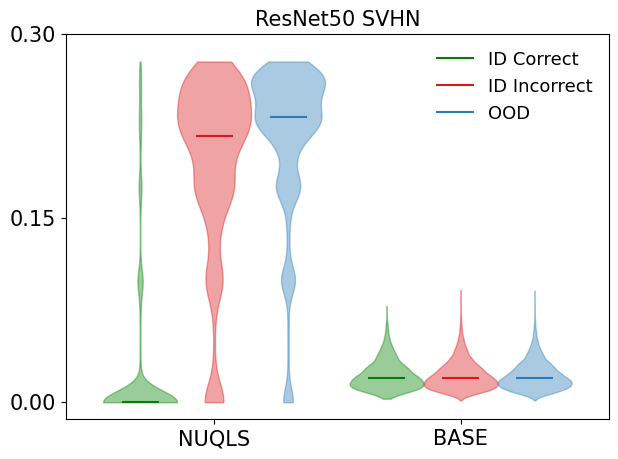

In [26]:
w, h, fs = 7, 5, 15
fig, (ax1) = plt.subplots(1,1,facecolor='white', figsize = (1*w,1*h), sharey=True)
fig.subplots_adjust(wspace=0)
ax_violin(ax1,svhn_nuqls_swag, legend_true=True, fs=fs, title='ResNet50 SVHN')
ax1.set_yticks(np.array((0,0.15,0.3)))

fig.show()
fig.savefig('violin_plot_uncertainty_svhn_nuqls.pdf',format='pdf',bbox_inches='tight')

C:\Users\s4531973\AppData\Local\Temp\ipykernel_10436\502827242.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


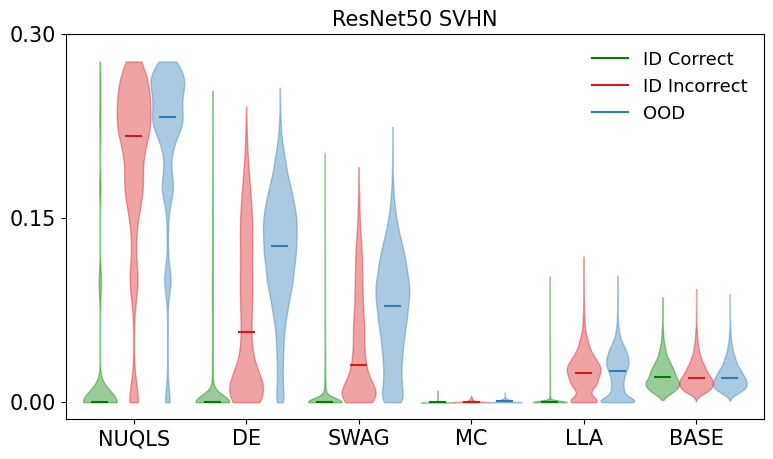

In [3]:
# svhn_original = torch.load('results\image_classification\svhn_resnet50\_7_5_11_35\prob_var_dict_0.pt')
svhn_original = torch.load('paper/pvd_r50_svhn.pt')

w, h, fs = 9, 5, 15
fig, (ax1) = plt.subplots(1,1,facecolor='white', figsize = (1*w,1*h), sharey=True)
fig.subplots_adjust(wspace=0)
ax_violin(ax1,svhn_original, legend_true=True, fs=fs, title='ResNet50 SVHN')
ax1.set_yticks(np.array((0,0.15,0.3)))

fig.show()
fig.savefig('violin_plot_uncertainty_svhn.pdf',format='pdf',bbox_inches='tight')


In [4]:
skew_median(svhn_original)

method = NUQLS
sample skew: id_correct = 2.2, id_incorrect = -1.31, ood = -1.78
pearsons first moment: id_correct = 0.445, id_incorrect = 2.58, ood = 3.28
pearsons second moment: id skew = 1.33, id skew = -1.0, ood_skew = -0.875
median id_correct = 8.61e-15, id_incorrect = 0.217, ood = 0.233, |diff| (ood-id_c) = 0.233

method = DE
sample skew: id_correct = 2.42, id_incorrect = 0.52, ood = -0.47
pearsons first moment: id_correct = 0.438, id_incorrect = 1.14, ood = 2.49
pearsons second moment: id skew = 1.31, id skew = 0.673, ood_skew = -0.308
median id_correct = 3.59e-06, id_incorrect = 0.0569, ood = 0.127, |diff| (ood-id_c) = 0.127

method = SWAG
sample skew: id_correct = 3.52, id_incorrect = 0.878, ood = -0.0119
pearsons first moment: id_correct = 0.354, id_incorrect = 1.04, ood = 1.78
pearsons second moment: id skew = 1.06, id skew = 1.06, ood_skew = -0.191
median id_correct = 1.71e-06, id_incorrect = 0.0302, ood = 0.0789, |diff| (ood-id_c) = 0.0789

method = MC
sample skew: id_corre

In [12]:
pvd_r9_fm = torch.load('paper/pvd_r9_fm.pt')
r9_fm_nuqls = torch.load(r'results\image_classification\resnet9_lenet\_12_5_13_59\prob_var_dict_0.pt')
pvd_r9_fm['NUQLS'] = r9_fm_nuqls['NUQLS']
torch.save(pvd_r9_fm, 'paper/pvd_r9_fm.pt')

C:\Users\s4531973\AppData\Local\Temp\ipykernel_10436\1287338061.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


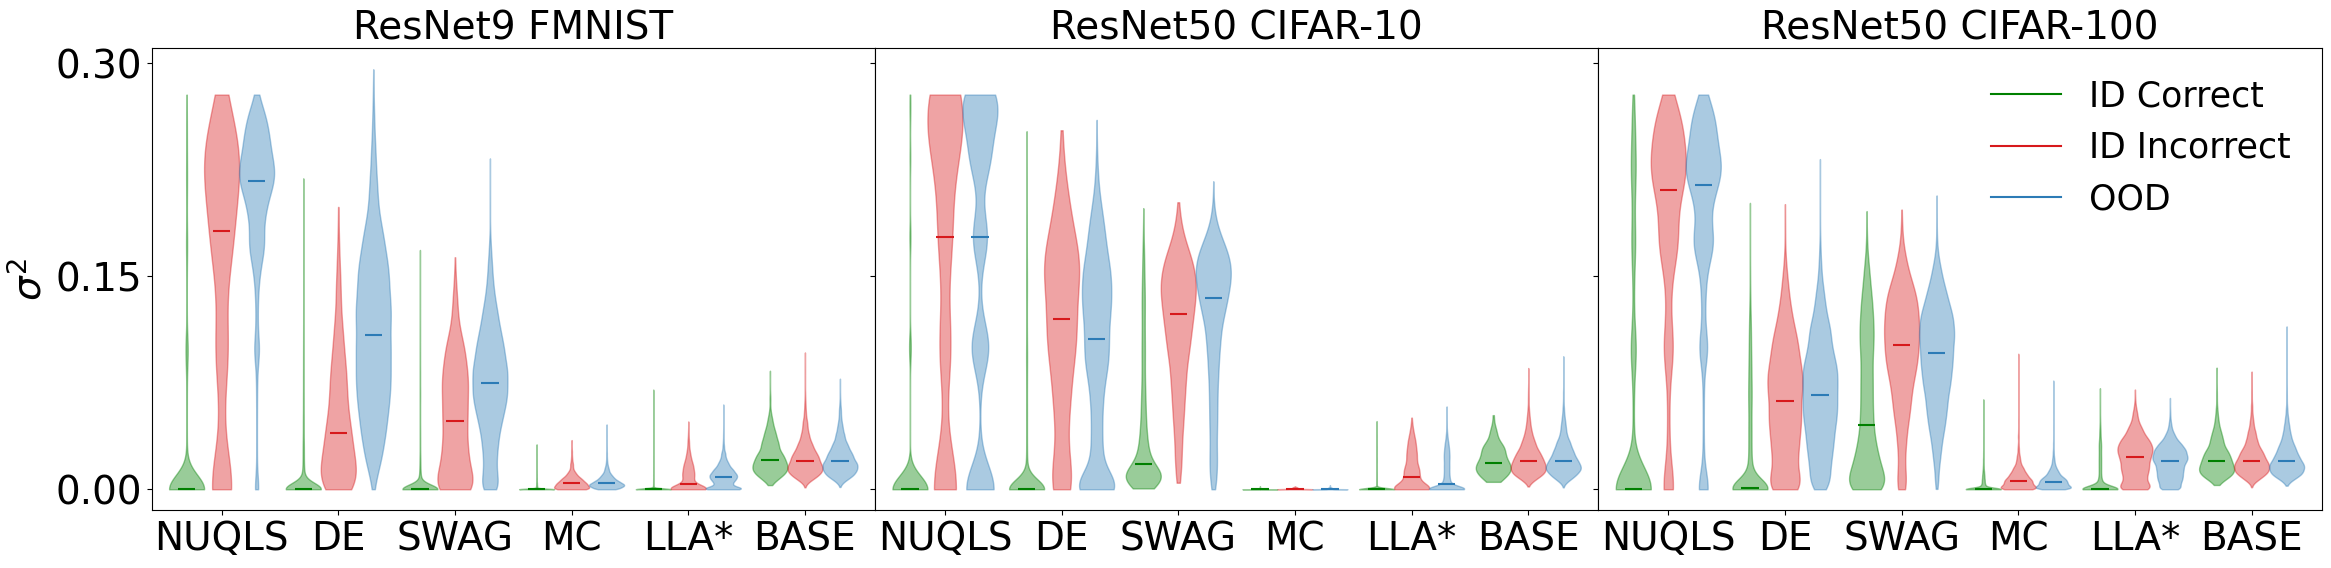

In [11]:
# pvd_r9_fm = torch.load('paper/pvd_r9_fm.pt')
pvd_r50_cifar = torch.load('paper/pvd_r50_cifar.pt')
pvd_r50_cifar100 = torch.load('paper/pvd_r50_cifar100.pt')
pvd_svhn_r50 = torch.load('results\image_classification\svhn_resnet50\_7_5_11_35\prob_var_dict_0.pt')

pvd_r9_fm['LLA*'] = pvd_r9_fm.pop('LLA')
pvd_r9_fm['BASE'] = pvd_r9_fm.pop('BASE')

pvd_r50_cifar['LLA*'] = pvd_r50_cifar.pop('LLA')
pvd_r50_cifar['BASE'] = pvd_r50_cifar.pop('BASE')

pvd_r50_cifar100['LLA*'] = pvd_r50_cifar100.pop('LLA')
pvd_r50_cifar100['BASE'] = pvd_r50_cifar100.pop('BASE')

w, h, fs = 28, 6, 28
fig, (ax1,ax2,ax3) = plt.subplots(1,3,facecolor='white', figsize = (1*w,1*h), sharey=True)
fig.subplots_adjust(wspace=0)
ax_violin(ax1,pvd_r9_fm, set_sigma=True, fs=fs, title='ResNet9 FMNIST')
ax_violin(ax2,pvd_r50_cifar, fs=fs, title='ResNet50 CIFAR-10')
ax_violin(ax3,pvd_r50_cifar100, legend_true=True, fs=fs, title='ResNet50 CIFAR-100')
ax1.set_yticks(np.array((0,0.15,0.3)))

fig.show()
fig.savefig('violin_plot_uncertainty.pdf',format='pdf',bbox_inches='tight')


In [12]:
skew_median(pvd_r9_fm)

method = NUQLS
sample skew: id_correct = 2.4, id_incorrect = -0.615, ood = -1.7
pearsons first moment: id_correct = 0.422, id_incorrect = 1.7, ood = 3.72
pearsons second moment: id skew = 1.27, id skew = -0.878, ood_skew = -0.749
median id_correct = 4.76e-15, id_incorrect = 0.182, ood = 0.217, |diff| (ood-id_c) = 0.217

method = DE
sample skew: id_correct = 3.51, id_incorrect = 0.928, ood = 0.321
pearsons first moment: id_correct = 0.377, id_incorrect = 1.17, ood = 2.0
pearsons second moment: id skew = 1.13, id skew = 0.719, ood_skew = 0.151
median id_correct = 1.31e-05, id_incorrect = 0.0397, ood = 0.109, |diff| (ood-id_c) = 0.109

method = SWAG
sample skew: id_correct = 3.72, id_incorrect = 0.378, ood = 0.0756
pearsons first moment: id_correct = 0.334, id_incorrect = 1.31, ood = 1.91
pearsons second moment: id skew = 1.0, id skew = 0.187, ood_skew = -0.0474
median id_correct = 4.64e-07, id_incorrect = 0.0478, ood = 0.0748, |diff| (ood-id_c) = 0.0748

method = MC
sample skew: id_corre

In [11]:
skew_median(pvd_r50_cifar)

method = NUQLS
sample skew: id_correct = 3.15, id_incorrect = -0.499, ood = -0.445
pearsons first moment: id_correct = 0.325, id_incorrect = 1.5, ood = 1.49
pearsons second moment: id skew = 0.974, id skew = -0.434, ood_skew = -0.501
median id_correct = 0.0, id_incorrect = 0.178, ood = 0.178, |diff| (ood-id_c) = 0.178

method = DE
sample skew: id_correct = 2.74, id_incorrect = -0.273, ood = -0.142
pearsons first moment: id_correct = 0.394, id_incorrect = 1.79, ood = 1.51
pearsons second moment: id skew = 1.18, id skew = -0.289, ood_skew = -0.412
median id_correct = 8.29e-08, id_incorrect = 0.12, ood = 0.106, |diff| (ood-id_c) = 0.106

method = SWAG
sample skew: id_correct = 1.37, id_incorrect = -0.604, ood = -0.832
pearsons first moment: id_correct = 0.881, id_incorrect = 2.58, ood = 2.52
pearsons second moment: id skew = 1.5, id skew = -0.549, ood_skew = -0.86
median id_correct = 0.0181, id_incorrect = 0.123, ood = 0.134, |diff| (ood-id_c) = 0.116

method = MC
sample skew: id_correct 

In [12]:
skew_median(pvd_r50_cifar100)

method = NUQLS
sample skew: id_correct = 1.08, id_incorrect = -1.15, ood = -1.37
pearsons first moment: id_correct = 0.683, id_incorrect = 2.38, ood = 2.68
pearsons second moment: id skew = 2.05, id skew = -1.07, ood_skew = -1.0
median id_correct = 1e-08, id_incorrect = 0.211, ood = 0.214, |diff| (ood-id_c) = 0.214

method = DE
sample skew: id_correct = 1.48, id_incorrect = 0.241, ood = 0.269
pearsons first moment: id_correct = 0.655, id_incorrect = 1.55, ood = 1.79
pearsons second moment: id skew = 1.9, id skew = 0.00992, ood_skew = 0.0895
median id_correct = 0.000873, id_incorrect = 0.0624, ood = 0.0665, |diff| (ood-id_c) = 0.0656

method = SWAG
sample skew: id_correct = 0.508, id_incorrect = -0.47, ood = -0.233
pearsons first moment: id_correct = 1.18, id_incorrect = 2.38, ood = 2.6
pearsons second moment: id skew = 0.776, id skew = -0.364, ood_skew = -0.226
median id_correct = 0.0449, id_incorrect = 0.101, ood = 0.0956, |diff| (ood-id_c) = 0.0507

method = MC
sample skew: id_correc

# CUQLS Comparison

In [22]:
pvd_r9_fm = torch.load('paper/pvd_r9_fm.pt')
pvd_r9_fm_cuqls = torch.load('paper/ck/pvd_r9_fm_cuqls.pt')
pvd_r9_fm_cuqls.pop('BASE')
pvd_r9_fm_cuqls['NUQLS'] = pvd_r9_fm['NUQLS']
pvd_r9_fm_cuqls['BASE'] = pvd_r9_fm['BASE']


svhn_original = torch.load('paper/pvd_r50_svhn.pt')
pvd_r50_svhn_cuqls = torch.load('paper/ck/pvd_r50_svhn_cuqls.pt')
pvd_r50_svhn_cuqls.pop('BASE')
pvd_r50_svhn_cuqls['NUQLS'] = svhn_original['NUQLS']
pvd_r50_svhn_cuqls['BASE'] = svhn_original['BASE']

C:\Users\s4531973\AppData\Local\Temp\ipykernel_25288\2160895217.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


ResNet9 FashionMNIST
method = CUQLS
sample skew: id_correct = 2.25, id_incorrect = -0.828, ood = -2.19
pearsons first moment: id_correct = 0.439, id_incorrect = 1.82, ood = 5.02
pearsons second moment: id skew = 1.32, id skew = -1.45, ood_skew = -0.422
median id_correct = 2.1e-22, id_incorrect = 0.22, ood = 0.233, |diff| (ood-id_c) = 0.233

method = NUQLS
sample skew: id_correct = 2.4, id_incorrect = -0.615, ood = -1.7
pearsons first moment: id_correct = 0.422, id_incorrect = 1.7, ood = 3.72
pearsons second moment: id skew = 1.27, id skew = -0.878, ood_skew = -0.749
median id_correct = 4.76e-15, id_incorrect = 0.182, ood = 0.217, |diff| (ood-id_c) = 0.217

method = BASE
sample skew: id_correct = 0.93, id_incorrect = 1.15, ood = 1.05
pearsons first moment: id_correct = 1.68, id_incorrect = 1.28, ood = 0.534
pearsons second moment: id skew = 0.658, id skew = 0.606, ood_skew = 0.623
median id_correct = 0.0206, id_incorrect = 0.0199, ood = 0.0199, |diff| (ood-id_c) = 0.000723


ResNet50 SV

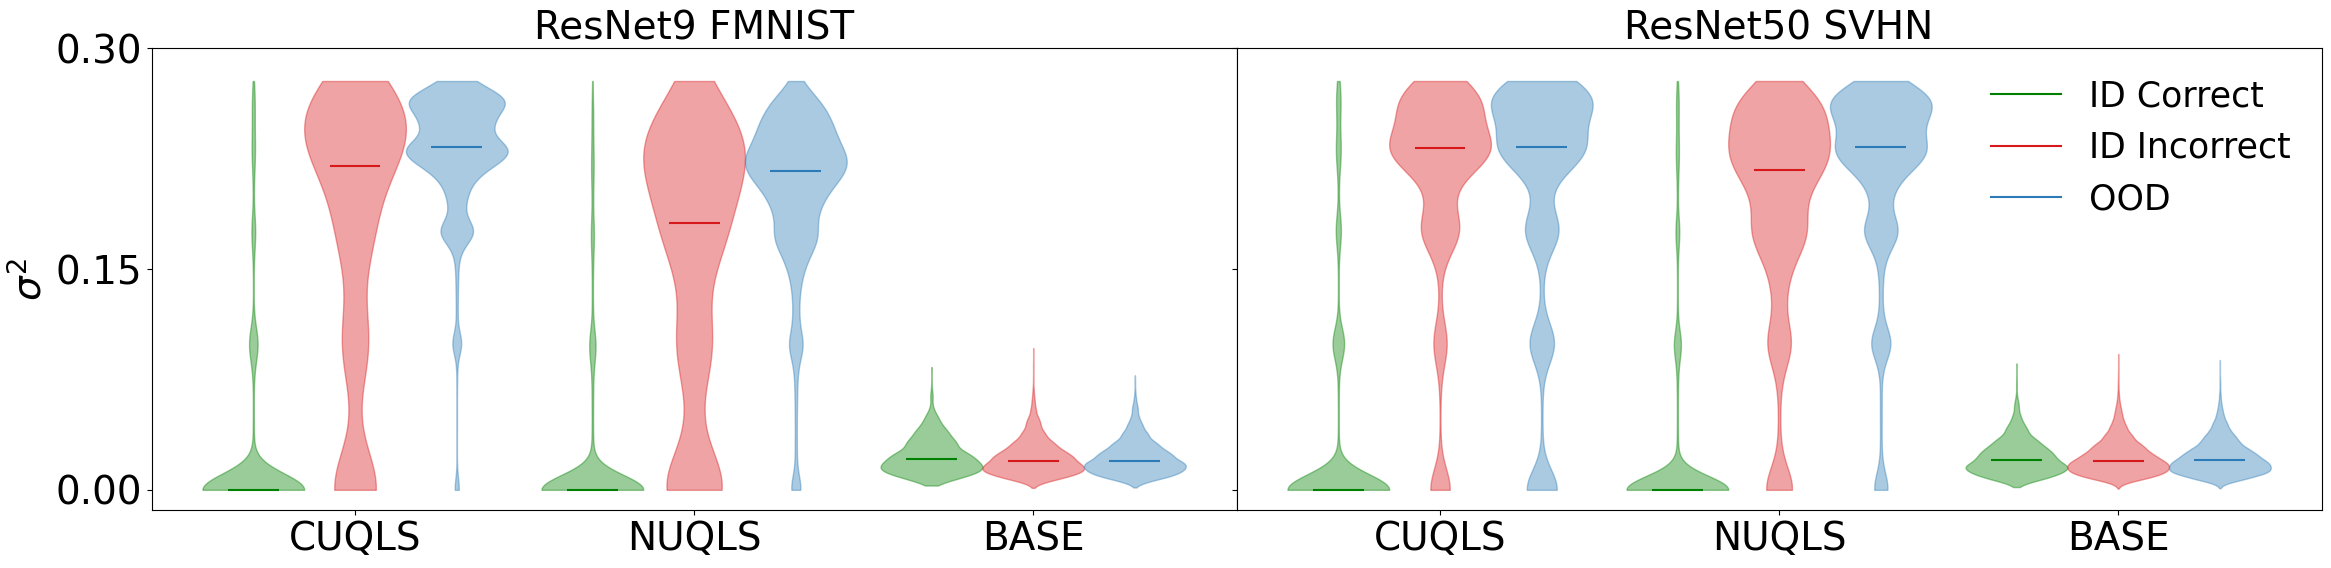

In [26]:
w, h, fs = 28, 6, 28
fig, (ax1,ax2) = plt.subplots(1,2,facecolor='white', figsize = (1*w,1*h), sharey=True)
fig.subplots_adjust(wspace=0)
ax_violin(ax1,pvd_r9_fm_cuqls, set_sigma=True, fs=fs, title='ResNet9 FMNIST')
ax_violin(ax2,pvd_r50_svhn_cuqls, legend_true=True, fs=fs, title='ResNet50 SVHN')
ax1.set_yticks(np.array((0,0.15,0.3)))

fig.show()
fig.savefig('violin_plot_uncertainty_cuqls.pdf',format='pdf',bbox_inches='tight')

print('ResNet9 FashionMNIST')
skew_median(pvd_r9_fm_cuqls)


print('\nResNet50 SVHN')
skew_median(pvd_r50_svhn_cuqls)

In [3]:
pvd = torch.load(r'C:\Users\s4531973\Documents\PhD\Code\nuqls\paper\sngp_prob_var_dict.pt')
skew_median(pvd)

method = SNGP
sample skew: id_correct = 29.8, id_incorrect = 24.4, ood = 1.21
pearsons first moment: id_correct = 0.257, id_incorrect = 0.384, ood = 2.43
pearsons second moment: id skew = 0.762, id skew = 0.376, ood_skew = 0.544
median id_correct = 9.19e-07, id_incorrect = 0.000322, ood = 0.000342, |diff| (ood-id_c) = 0.000341

method = BASE
sample skew: id_correct = 1.08, id_incorrect = 1.09, ood = 1.06
pearsons first moment: id_correct = 1.81, id_incorrect = 1.68, ood = 1.81
pearsons second moment: id skew = 0.56, id skew = 0.591, ood_skew = 0.623
median id_correct = 0.0197, id_incorrect = 0.0199, ood = 0.0198, |diff| (ood-id_c) = 4.32e-05



In [6]:
pvd = torch.load(r'C:\Users\s4531973\Documents\PhD\Code\nuqls\paper\sngp_prob_var_dict_2.pt')
skew_median(pvd)

method = SNGP
sample skew: id_correct = 0.309, id_incorrect = 0.284, ood = 0.304
pearsons first moment: id_correct = 2.93, id_incorrect = 3.43, ood = 3.15
pearsons second moment: id skew = 0.154, id skew = 0.158, ood_skew = 0.177
median id_correct = 3.64e-06, id_incorrect = 3.64e-06, ood = 3.66e-06, |diff| (ood-id_c) = 1.55e-08

method = BASE
sample skew: id_correct = 1.16, id_incorrect = 1.06, ood = 1.06
pearsons first moment: id_correct = 1.68, id_incorrect = 1.78, ood = 1.77
pearsons second moment: id skew = 0.669, id skew = 0.615, ood_skew = 0.629
median id_correct = 0.0198, id_incorrect = 0.02, ood = 0.02, |diff| (ood-id_c) = 0.000126



In [5]:
pvd = torch.load(r'C:\Users\s4531973\Documents\PhD\Code\nuqls\paper\pvd_imagenet.pt', map_location=torch.device('cpu'))
skew_median(pvd)

method = NUQLS
sample skew: id_correct = 2.56, id_incorrect = -0.572, ood = 0.179
pearsons first moment: id_correct = 0.385, id_incorrect = 1.55, ood = 1.05
pearsons second moment: id skew = 1.15, id skew = -1.33, ood_skew = 0.455
median id_correct = 0.0, id_incorrect = 0.212, ood = 0.1, |diff| (ood-id_c) = 0.1

method = BASE
sample skew: id_correct = 1.21, id_incorrect = 1.1, ood = 0.985
pearsons first moment: id_correct = 1.25, id_incorrect = 1.64, ood = 1.72
pearsons second moment: id skew = 0.319, id skew = 0.643, ood_skew = 0.619
median id_correct = 0.0206, id_incorrect = 0.0197, ood = 0.0197, |diff| (ood-id_c) = 0.000867



In [8]:
pvd = torch.load(r'C:\Users\s4531973\Documents\PhD\Code\nuqls\paper\pvd_imagenet2.pt', map_location=torch.device('cpu'))
skew_median(pvd)

method = NUQLS
sample skew: id_correct = 1.52, id_incorrect = -0.88, ood = 0.179
pearsons first moment: id_correct = 0.559, id_incorrect = 1.82, ood = 1.05
pearsons second moment: id skew = 1.68, id skew = -1.53, ood_skew = 0.455
median id_correct = 0.0, id_incorrect = 0.232, ood = 0.1, |diff| (ood-id_c) = 0.1

method = BASE
sample skew: id_correct = 1.31, id_incorrect = 1.09, ood = 1.07
pearsons first moment: id_correct = 1.13, id_incorrect = 1.79, ood = 1.75
pearsons second moment: id skew = 1.21, id skew = 0.61, ood_skew = 0.578
median id_correct = 0.0157, id_incorrect = 0.0199, ood = 0.0205, |diff| (ood-id_c) = 0.00474



method = NUQLS
sample skew: id_correct = 3.1, id_incorrect = -0.342, ood = -0.0875
pearsons first moment: id_correct = 0.33, id_incorrect = 1.37, ood = 1.25
pearsons second moment: id skew = 0.991, id skew = -0.678, ood_skew = -1.03
median id_correct = 0.0, id_incorrect = 0.178, ood = 0.173, |diff| (ood-id_c) = 0.173

method = BE
sample skew: id_correct = 2.8, id_incorrect = 0.944, ood = -0.272
pearsons first moment: id_correct = 0.463, id_incorrect = 1.5, ood = 2.35
pearsons second moment: id skew = 1.38, id skew = 0.386, ood_skew = -0.174
median id_correct = 8.31e-05, id_incorrect = 0.045, ood = 0.107, |diff| (ood-id_c) = 0.107

method = BASE
sample skew: id_correct = 1.03, id_incorrect = 1.13, ood = 1.11
pearsons first moment: id_correct = 1.71, id_incorrect = 1.77, ood = 1.76
pearsons second moment: id skew = 0.495, id skew = 0.628, ood_skew = 0.641
median id_correct = 0.0201, id_incorrect = 0.0199, ood = 0.0198, |diff| (ood-id_c) = 0.000203



C:\Users\s4531973\AppData\Local\Temp\ipykernel_16256\1298320546.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


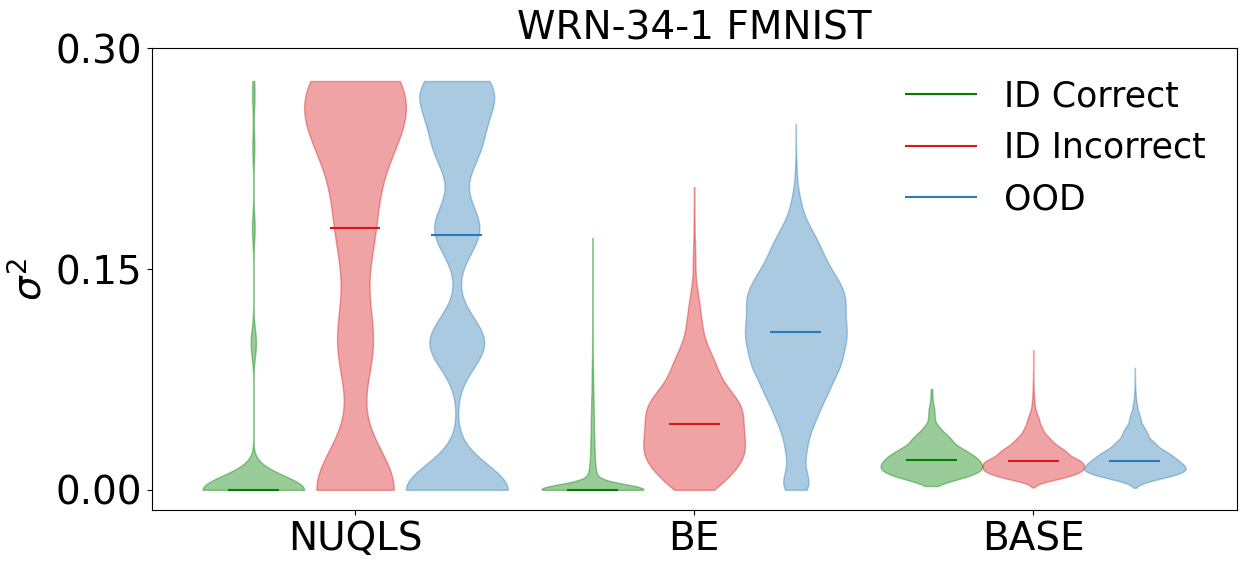

In [5]:
pvd = torch.load(r'C:\Users\s4531973\Documents\PhD\Code\nuqls\paper\smallwrn_fmnist_be_good.pt')
pvd_nuqls = torch.load(r'C:\Users\s4531973\Documents\PhD\Code\nuqls\paper\smallwrn_fmnist_nuqls_good.pt')
pvd['NUQLS'] = pvd_nuqls['NUQLS']
skew_median(pvd)

w, h, fs = 14, 6, 28
fig, (ax1) = plt.subplots(1,1,facecolor='white', figsize = (1*w,1*h), sharey=True)
fig.subplots_adjust(wspace=0)
ax_violin(ax1,pvd, legend_true=True, set_sigma=True, fs=fs, title='WRN-34-1 FMNIST')
ax1.set_yticks(np.array((0,0.15,0.3)))

fig.show()
fig.savefig('violin_plot_uncertainty_wrn.pdf',format='pdf',bbox_inches='tight')

method = NUQLS
sample skew: id_correct = 2.4, id_incorrect = -0.615, ood = -1.7
pearsons first moment: id_correct = 0.422, id_incorrect = 1.7, ood = 3.72
pearsons second moment: id skew = 1.27, id skew = -0.878, ood_skew = -0.749
median id_correct = 4.76e-15, id_incorrect = 0.182, ood = 0.217, |diff| (ood-id_c) = 0.217

method = DE
sample skew: id_correct = 3.51, id_incorrect = 0.928, ood = 0.321
pearsons first moment: id_correct = 0.377, id_incorrect = 1.17, ood = 2.0
pearsons second moment: id skew = 1.13, id skew = 0.719, ood_skew = 0.151
median id_correct = 1.31e-05, id_incorrect = 0.0397, ood = 0.109, |diff| (ood-id_c) = 0.109

method = BDE
sample skew: id_correct = 6.46, id_incorrect = 1.43, ood = 0.515
pearsons first moment: id_correct = 0.191, id_incorrect = 0.72, ood = 1.04
pearsons second moment: id skew = 0.573, id skew = 1.67, ood_skew = 0.392
median id_correct = 3.35e-20, id_incorrect = 0.00915, ood = 0.0504, |diff| (ood-id_c) = 0.0504

method = SGLD
sample skew: id_correc

C:\Users\s4531973\AppData\Local\Temp\ipykernel_9304\1190130715.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


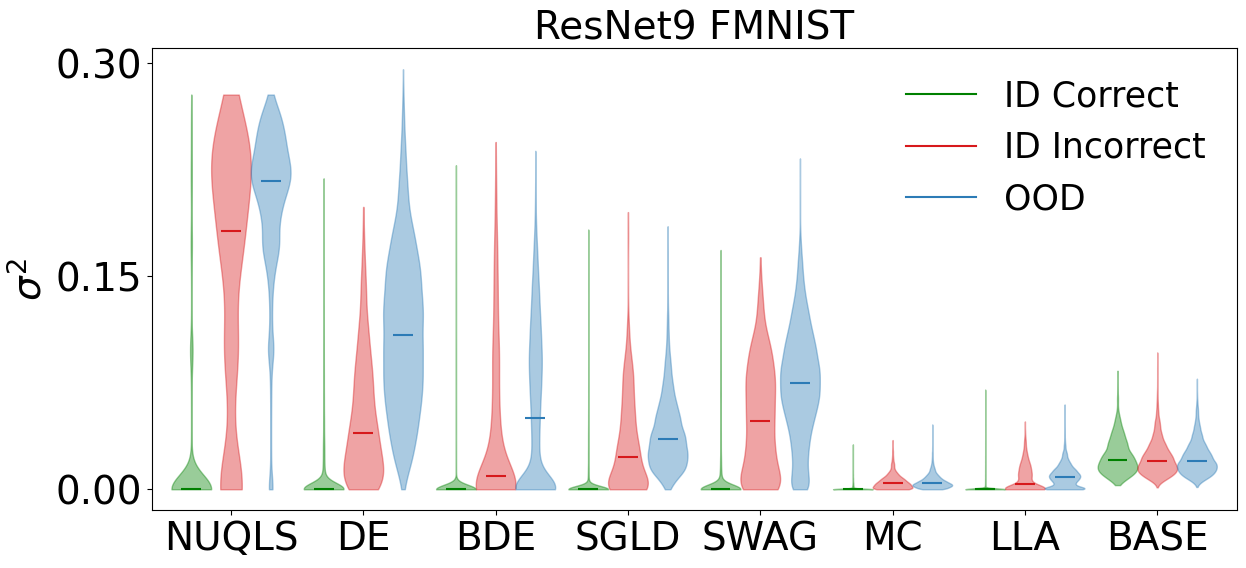

In [4]:
pvd_r9_fm = torch.load('paper/pvd_r9_fm.pt')
pvd_be = torch.load('paper/fmnist_resnet9_bde.pt')
pvd_r9_fm['BDE'] = pvd_be['BDE']
pvd_sgld = torch.load('paper/fmnist_resnet9_sgld.pt')
pvd_r9_fm['SGLD'] = pvd_sgld['SGLD']
key_it = list(pvd_r9_fm.keys())

for k in key_it:
    if k in ['NUQLS','DE','BDE','SGLD']:
        continue
    else:
        pvd_r9_fm[k] = pvd_r9_fm.pop(k)

skew_median(pvd_r9_fm)

w, h, fs = 14, 6, 28
fig, (ax1) = plt.subplots(1,1,facecolor='white', figsize = (1*w,1*h), sharey=True)
fig.subplots_adjust(wspace=0)
ax_violin(ax1,pvd_r9_fm, legend_true=True, set_sigma=True, fs=fs, title='ResNet9 FMNIST')
ax1.set_yticks(np.array((0,0.15,0.3)))

fig.show()
fig.savefig('violin_plot_uncertainty_sgld.pdf',format='pdf',bbox_inches='tight')